In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 1147, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1147 (delta 47), reused 40 (delta 36), pack-reused 1077 (from 1)
Receiving objects: 100% (1147/1147), 30.19 MiB | 20.44 MiB/s, done.
Resolving deltas: 100% (704/704), done.
Filtering content: 100% (33/33), 1.75 GiB | 152.41 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install pykalman
!pip install ta
!pip install scikit-optimize

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0

  Using cached peft-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux

In [6]:
# bunch of the initialization code #

### RESULTS IMPORTS ###
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any, Sequence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoConfig
from torch.utils.data import DataLoader, TensorDataset

# Custom Imports
from models.statistical_models import kalman_filter_average, kalman_filter_regression
from models.transformer_model import TimeSeriesTransformerv1, get_cosine_schedule_with_warmup_and_min_lr
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac
from external.time_moe_repo.training_wrapper import train_time_moe
from backtesting.trading_strategy import get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty

## semi-custom
from external.time_moe_repo.time_moe.models.modeling_time_moe import TimeMoeForPrediction

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###


### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

## workflow imports
from models.statistical_models import execute_kalman_workflow

## optimize-specific imports
from skopt import gp_minimize
from skopt import plots as skplots
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np
from typing import Callable, Any, List, Dict, Tuple
import time
import random
from sklearn.metrics import mean_squared_error
from functools import partial


from utils.helpers import return_score
from utils.visualization import results_to_latex
from utils.optimization import bayesian_optimize_workflow
### HYPERPARAM OPTIMIZATION IMPORTS ###

# 1. Optimization

## Kalman Filter

In [ ]:
search_space_kalman = [ # 'name' is used directly as a kwarg
    Real(1e-5, 0.1, name='delta', prior='log-uniform'),
    Real(0.5, 4, name='obs_cov_reg', prior='log-uniform'),
    Real(0.001, 0.1, name='trans_cov_avg', prior='log-uniform'),
    Real(0.1, 10, name='obs_cov_avg', prior='log-uniform')
]
SEED = 3178749

# call func
res_kalman = bayesian_optimize_workflow(
    execute_workflow_fn=execute_kalman_workflow,
    top_pair_count=3,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2019,
    search_space=search_space_kalman,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_kalman]
best_params = {k: res_kalman.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_kalman.fun
print(f"best_params: {best_params}")
print(f"best_mean_mse: {best_mean_mse}")

In [ ]:
print(f"best_params: {best_params}")
print(f"best_mean_mse: {best_mean_mse}")
# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_kalman, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_kalman)
ax.set_title("Bayesian Optimization Convergence plot Kalman Filter")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

## Transformer

In [53]:
search_space_transformer = [ # 'name' is used directly as a kwarg
  ## optimized hyperparams: architecture ##
  Categorical([256, 512, 1024], name='d_model'),  # must be powers of 2
  Categorical([2, 8, 16], name='nhead'),
  Integer(2, 6, name='num_layers'),
  Real(0.0, 0.3, name='dropout'),
  ## optimized hyperparams: architecture ##

  ## optimized hyperparams: learning algorithm ##
  Real(1e-6, 1e-4, prior='log-uniform', name='learning_rate'), # too high of a learning rate will cause exploding gradients, resulting in very high MSE or nans in outputs
  Real(1e-6, 1e-4, prior='log-uniform', name='min_learning_rate'),
  Real(0.0, 0.05, name='warmup_ratio'),
  Real(0.0, 0.3, name='weight_decay'),
  Categorical([64, 128], name='batch_size'),
  Real(0.85, 0.99, name='adam_beta1'),
  Real(0.9, 0.999, name='adam_beta2'),
  Real(1e-11, 1e-8, prior='log-uniform', name='adam_epsilon')
  ## optimized hyperparams: learning algorithm ##
]

SEED = 3178749

fixed_params = {'epochs': 10}
execute_transformer_workflow_fixed_params = partial(execute_transformer_workflow, **fixed_params)

# call func
res_transformer = bayesian_optimize_workflow(
    execute_workflow_fn=execute_transformer_workflow_fixed_params,
    top_pair_count=1,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2019,
    search_space=search_space_transformer,
    n_calls=30,
    seed=SEED,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Current hyperparameters: {'d_model': 512, 'nhead': 2, 'num_layers': 6, 'dropout': 0.24532990507861047, 'learning_rate': 3.543313023647247e-05, 'min_learning_rate': 3.1114452922599073e-06, 'warmup_ratio': 0.04161462758883802, 'weight_decay': 0.14372393142085188, 'batch_size': 128, 'adam_beta1': 0.9873355316199921, 'adam_beta2': 0.91648264436139, 'adam_epsilon': 4.664012054704713e-10}
Epoch 010 | train MSE 0.116536 | val MSE 0.091099
Epoch 010 | train MSE 0.100529 | val MSE 0.059017
Epoch 010 | train MSE 0.114353 | val MSE 0.012783
Epoch 010 | train MSE 0.148236 | val MSE 0.280005
total_mse_list: [7.934625049682245, 6.640895915550856, 0.5313675556766491, 7.04900135341144]
mean mse: 5.5389724685802975
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 42.5355
Function value obtained: 5.5390
Current minimum: 5.5390
Iteration No: 2 started. Evaluating function at random point.
Current hyperparameters: {'d_model':

In [54]:
param_names_transformer = [dim.name for dim in search_space_transformer]
best_params_transformer = {k: res_transformer.x[i] for i, k in enumerate(param_names_transformer)}
best_mean_mse_transformer = res_transformer.fun
print(f"best_params: {best_params_transformer}")
print(f"best_mean_mse: {best_mean_mse_transformer}")

best_params: {'d_model': 256, 'nhead': 8, 'num_layers': 3, 'dropout': 0.1423652841511892, 'learning_rate': 2.4360790710388177e-06, 'min_learning_rate': 8.416991137830168e-05, 'warmup_ratio': 0.01016486209190529, 'weight_decay': 0.27550315286937016, 'batch_size': 64, 'adam_beta1': 0.9595914559778183, 'adam_beta2': 0.9696258195959361, 'adam_epsilon': 5.235073338871379e-10}
best_mean_mse: 0.5856978985989921


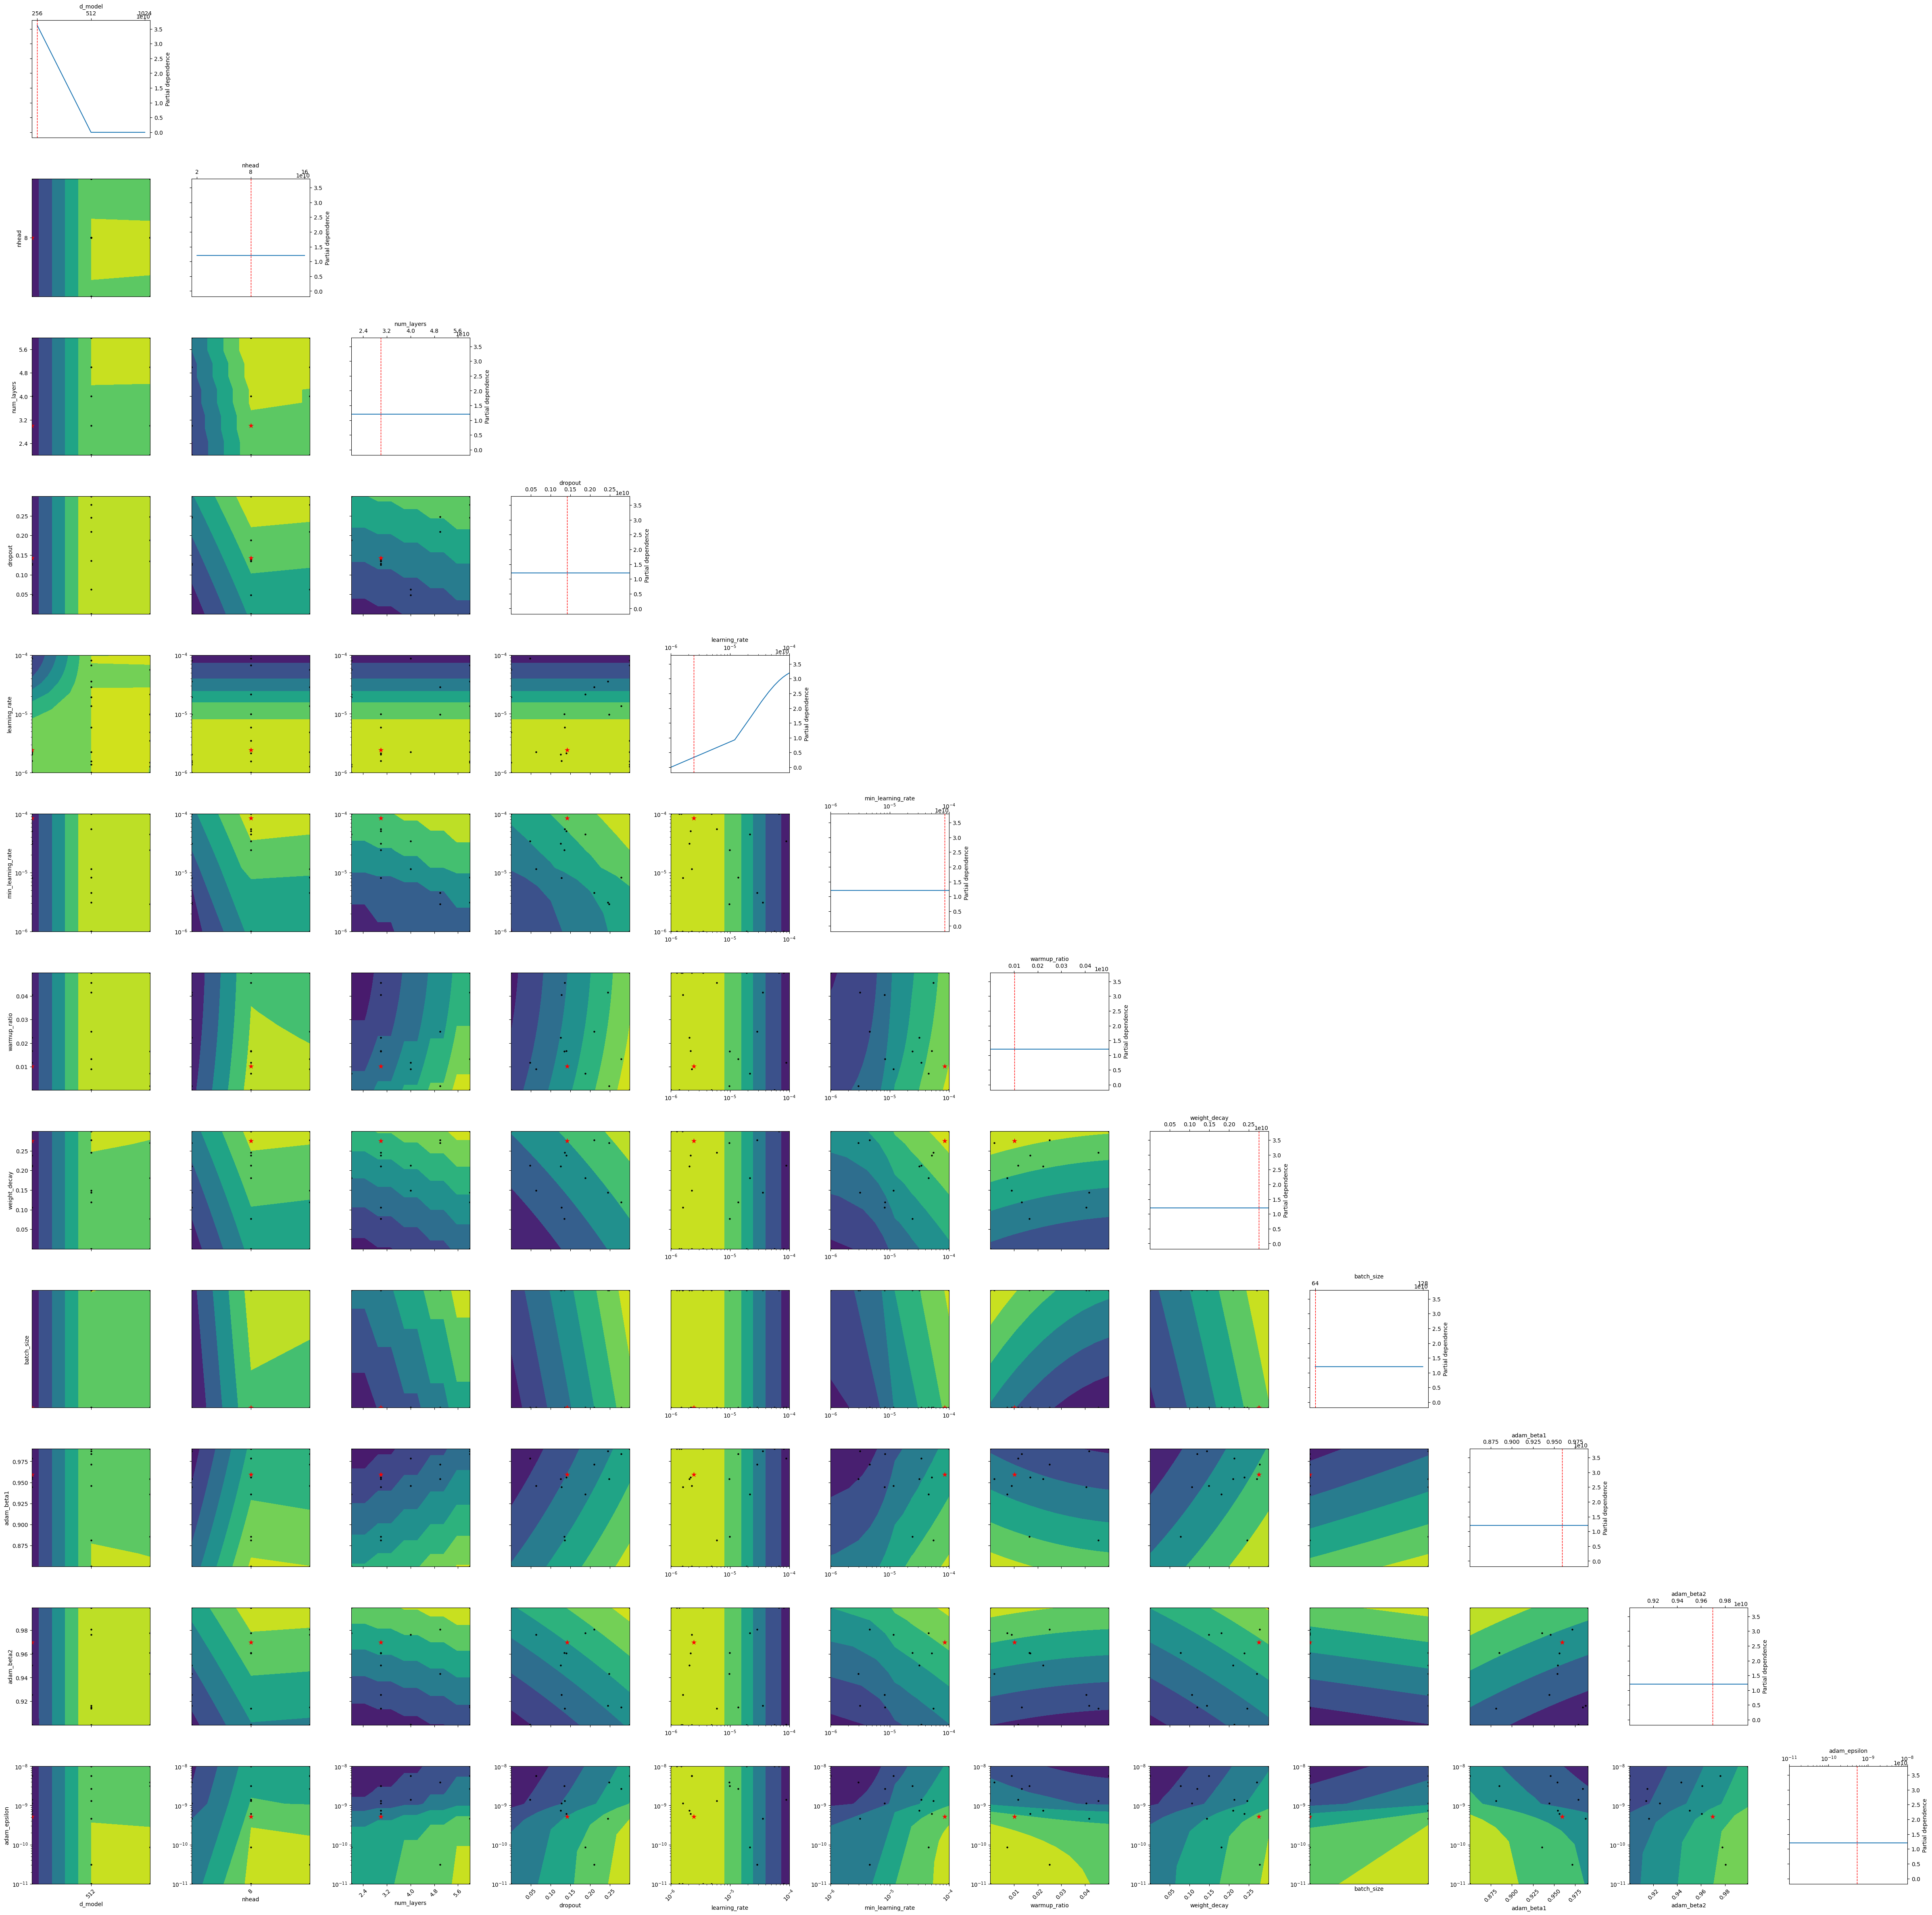

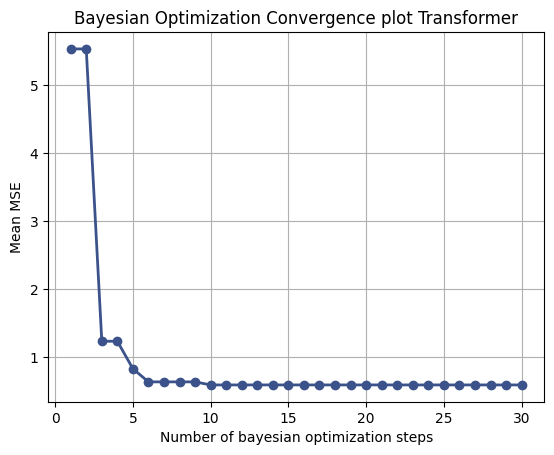

In [55]:
# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_transformer, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_transformer)
ax.set_title("Bayesian Optimization Convergence plot Transformer")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

## Time-MoE

In [77]:
search_space_timemoe = [ # 'name' is used directly as a kwarg
  ## optimized hyperparams: learning algorithm ##
  Real(1e-6, 1e-4, prior='log-uniform', name='learning_rate'), # too high of a learning rate will cause exploding gradients, resulting in very high MSE or nans in outputs
  Real(1e-6, 1e-4, prior='log-uniform', name='min_learning_rate'),
  Real(0.0, 0.05, name='warmup_ratio'),
  Real(0.0, 0.3, name='weight_decay'),
  Categorical([64, 128], name='batch_size'),
  Real(0.85, 0.99, name='adam_beta1'),
  Real(0.9, 0.999, name='adam_beta2'),
  Real(1e-11, 1e-8, prior='log-uniform', name='adam_epsilon')
  ## optimized hyperparams: learning algorithm ##
]
SEED = 3178749

# call func
res_timemoe = bayesian_optimize_workflow(
    execute_workflow_fn=execute_timemoe_workflow,
    top_pair_count=1,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2019,
    search_space=search_space_timemoe,
    n_calls=30,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_timemoe]
best_params = {k: res_timemoe.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_timemoe.fun

Iteration No: 1 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}
2025-06-16 17:33:19,830 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2621.44it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:33:25,030 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2880.70it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:33:30,048 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 1998.24it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:33:35,543 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 1931.08it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.4427
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 2 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 3.426154615849745e-05, 'min_learning_rate': 9.160858309833609e-05, 'warmup_ratio': 0.008324567859287892, 'weight_decay': 0.16687596642391597, 'batch_size': 64, 'adam_beta1': 0.9089354148779092, 'adam_beta2': 0.9616380065480887, 'adam_epsilon': 3.006622954548625e-11}
2025-06-16 17:33:42,219 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2538.92it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:33:47,443 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3771.86it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:33:52,583 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2212.19it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:33:57,856 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3216.49it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 21.0963
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 3 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 8.830965232159592e-05, 'min_learning_rate': 3.424859195383696e-05, 'warmup_ratio': 0.01168563921691556, 'weight_decay': 0.2127749148484082, 'batch_size': 64, 'adam_beta1': 0.9785553685576249, 'adam_beta2': 0.9002924364184774, 'adam_epsilon': 1.41830236888153e-09}
2025-06-16 17:34:03,308 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4599.02it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:08,200 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4462.03it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:13,605 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5932.54it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:18,884 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 1362.67it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 21.5316
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 4 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 2.061962256331083e-05, 'min_learning_rate': 3.801125176371274e-05, 'warmup_ratio': 0.036008737636124596, 'weight_decay': 0.20994270385992123, 'batch_size': 128, 'adam_beta1': 0.8960244194548778, 'adam_beta2': 0.9494211313960338, 'adam_epsilon': 6.034577184973604e-09}
2025-06-16 17:34:24,867 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2601.93it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:29,724 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2310.91it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:34,785 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2636.27it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:39,974 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 20.7816
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 5 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 3.8532649225825855e-06, 'min_learning_rate': 5.43532088247193e-05, 'warmup_ratio': 0.04062324873823531, 'weight_decay': 0.04871635037633412, 'batch_size': 64, 'adam_beta1': 0.9029628740429356, 'adam_beta2': 0.9132358672824176, 'adam_epsilon': 2.2883200304747968e-10}
2025-06-16 17:34:45,639 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:50,622 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5029.14it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:34:56,229 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4524.60it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:01,906 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2153.13it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 21.7159
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 6 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 5.928814032392102e-06, 'min_learning_rate': 5.469825836261845e-05, 'warmup_ratio': 0.04563064276122492, 'weight_decay': 0.24594992467363028, 'batch_size': 64, 'adam_beta1': 0.8811602429987699, 'adam_beta2': 0.9140999216428032, 'adam_epsilon': 1.3036928150420823e-09}
2025-06-16 17:35:07,350 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3113.81it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:12,763 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2337.96it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:18,002 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3994.58it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:23,320 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2489.20it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 21.5603
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 7 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 5.8853415539448134e-05, 'min_learning_rate': 9.020482107494073e-06, 'warmup_ratio': 0.0036360942851451205, 'weight_decay': 0.18827524005553803, 'batch_size': 128, 'adam_beta1': 0.9658110794594795, 'adam_beta2': 0.9140201539785365, 'adam_epsilon': 6.426970542603885e-10}
2025-06-16 17:35:28,910 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:33,680 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5336.26it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:38,681 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4112.06it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:44,034 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3949.44it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 20.8839
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 8 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 8.629943239721477e-06, 'min_learning_rate': 1.6752338415288314e-05, 'warmup_ratio': 0.03919575929957089, 'weight_decay': 0.09347607399263154, 'batch_size': 128, 'adam_beta1': 0.8854170989931313, 'adam_beta2': 0.9680697149224714, 'adam_epsilon': 3.0133445050546737e-09}
2025-06-16 17:35:49,809 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5084.00it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:54,554 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4500.33it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:35:59,545 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4614.20it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:04,712 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3847.99it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 20.3923
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 9 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 9.764790912705491e-06, 'min_learning_rate': 2.922196524405459e-06, 'warmup_ratio': 0.0016862876483049632, 'weight_decay': 0.2707898652499198, 'batch_size': 128, 'adam_beta1': 0.9540029481540556, 'adam_beta2': 0.9432541541354257, 'adam_epsilon': 3.938737632229208e-09}
2025-06-16 17:36:10,187 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4232.40it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:15,022 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2870.84it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:19,969 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2736.01it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:25,418 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4355.46it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 20.8026
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 10 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 1.4729211625598468e-05, 'min_learning_rate': 9.811584140546962e-05, 'warmup_ratio': 0.020042798239678073, 'weight_decay': 0.06301522871836365, 'batch_size': 64, 'adam_beta1': 0.9242963004350766, 'adam_beta2': 0.9179111657422258, 'adam_epsilon': 3.060943874202319e-10}
2025-06-16 17:36:30,990 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2995.93it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:35,864 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:40,918 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 6052.39it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:46,080 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 20.9297
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 11 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.3751301029806042e-05, 'min_learning_rate': 3.0276737253078593e-06, 'warmup_ratio': 0.008310661579449782, 'weight_decay': 0.292292579214643, 'batch_size': 128, 'adam_beta1': 0.8519270576651703, 'adam_beta2': 0.9743397613858844, 'adam_epsilon': 7.324098881510257e-11}
2025-06-16 17:36:51,942 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:36:56,763 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4686.37it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:02,200 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2540.46it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:07,614 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2768.52it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 22.7147
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 12 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.507816566977783e-06, 'min_learning_rate': 6.02340565236591e-05, 'warmup_ratio': 0.008826366863130588, 'weight_decay': 0.026741151881577777, 'batch_size': 128, 'adam_beta1': 0.986912625007048, 'adam_beta2': 0.9798516661196743, 'adam_epsilon': 1.2855820902835883e-11}
2025-06-16 17:37:14,654 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5053.38it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:19,430 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2490.68it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:24,430 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4905.62it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:29,701 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 20.7318
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 13 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.0174962421032467e-06, 'min_learning_rate': 1.0809572377292123e-05, 'warmup_ratio': 0.04498593526126246, 'weight_decay': 0.2799736760192171, 'batch_size': 128, 'adam_beta1': 0.9050733757293803, 'adam_beta2': 0.9067265898537124, 'adam_epsilon': 1.2458619625327218e-11}
2025-06-16 17:37:35,387 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2071.26it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:40,174 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4387.35it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:45,183 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3008.83it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:37:51,138 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2511.56it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 21.5582
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 14 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 9.347247767041803e-05, 'min_learning_rate': 1.3780799799222523e-06, 'warmup_ratio': 0.014947612681334052, 'weight_decay': 0.2955261776313673, 'batch_size': 128, 'adam_beta1': 0.8962506467779787, 'adam_beta2': 0.9887814375621125, 'adam_epsilon': 1.768095301759586e-11}
2025-06-16 17:37:56,939 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2761.23it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:02,023 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4681.14it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:07,043 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4696.87it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:12,477 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4068.19it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 21.4576
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 15 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 6.590859370573866e-06, 'min_learning_rate': 3.133055219408788e-05, 'warmup_ratio': 0.04783812666191359, 'weight_decay': 0.19942335051725435, 'batch_size': 128, 'adam_beta1': 0.9721776656548753, 'adam_beta2': 0.9858175912372186, 'adam_epsilon': 1.2428090255063537e-09}
2025-06-16 17:38:18,403 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4798.97it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:23,182 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3628.29it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:28,230 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3221.43it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:33,554 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4975.45it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 21.4439
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 16 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 3.931915389275348e-06, 'min_learning_rate': 1.2115266491331165e-06, 'warmup_ratio': 0.02640082499340308, 'weight_decay': 0.2865425697500441, 'batch_size': 128, 'adam_beta1': 0.854269941596147, 'adam_beta2': 0.9396925721711913, 'adam_epsilon': 2.2801998735523504e-10}
2025-06-16 17:38:39,852 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4951.95it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:44,653 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5729.92it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:49,869 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5599.87it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:38:55,384 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5084.00it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 21.3086
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 17 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 4.451158544014036e-05, 'min_learning_rate': 1.1841172587455029e-06, 'warmup_ratio': 0.04427347441219375, 'weight_decay': 0.019742623440693677, 'batch_size': 128, 'adam_beta1': 0.9354090469970062, 'adam_beta2': 0.9123036447003906, 'adam_epsilon': 1.1764524851544335e-11}
2025-06-16 17:39:01,154 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4981.36it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:05,932 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4387.35it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:11,147 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2529.74it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:16,635 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2061.08it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 21.1678
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 18 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 2.3031942800399493e-06, 'min_learning_rate': 2.0579593196283684e-06, 'warmup_ratio': 0.04186252664925824, 'weight_decay': 0.23563189137040635, 'batch_size': 128, 'adam_beta1': 0.8741717146752411, 'adam_beta2': 0.9630609062612512, 'adam_epsilon': 3.701373314879931e-11}
2025-06-16 17:39:22,335 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2490.68it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:27,635 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4951.95it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:32,708 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4424.37it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:37,955 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 1897.02it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 21.3611
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 19 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.1396923396925171e-06, 'min_learning_rate': 1.7413993310707e-06, 'warmup_ratio': 0.008198662589922558, 'weight_decay': 0.009188761880021181, 'batch_size': 128, 'adam_beta1': 0.852378796066193, 'adam_beta2': 0.9551829243068359, 'adam_epsilon': 4.6828475403470205e-09}
2025-06-16 17:39:43,705 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5171.77it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:48,404 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4284.27it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:53,450 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5171.77it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:39:58,608 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4766.25it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 20.9389
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 20 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.1584147339566874e-05, 'min_learning_rate': 9.42945231396684e-06, 'warmup_ratio': 0.03423426673243318, 'weight_decay': 0.19949856561543927, 'batch_size': 128, 'adam_beta1': 0.8974105010043194, 'adam_beta2': 0.967826066699397, 'adam_epsilon': 2.1941229404027924e-09}
2025-06-16 17:40:04,648 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4686.37it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:09,394 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4691.62it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:14,625 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4771.68it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:19,791 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 20.7319
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 21 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 2.2690379843931968e-05, 'min_learning_rate': 5.642349904622785e-06, 'warmup_ratio': 0.036789910815252895, 'weight_decay': 0.18243021607092874, 'batch_size': 64, 'adam_beta1': 0.9436260828152973, 'adam_beta2': 0.9683392946235355, 'adam_epsilon': 9.250520859209297e-10}
2025-06-16 17:40:25,376 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2593.88it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:30,267 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:35,421 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3905.31it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:42,232 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4681.14it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 22.5548
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 22 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 8.459664443604977e-05, 'min_learning_rate': 6.328812926363298e-05, 'warmup_ratio': 0.00043358948960406385, 'weight_decay': 0.029403176821401474, 'batch_size': 128, 'adam_beta1': 0.8726255043155071, 'adam_beta2': 0.9026304828546297, 'adam_epsilon': 1.9076466772423618e-10}
2025-06-16 17:40:47,925 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4696.87it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:52,721 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2713.00it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:40:57,734 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4165.15it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:03,081 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4614.20it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 20.9309
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 23 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.9215004957481265e-06, 'min_learning_rate': 1.3458446344324681e-06, 'warmup_ratio': 0.00946438486733872, 'weight_decay': 0.0060668021988221415, 'batch_size': 128, 'adam_beta1': 0.9878510513438725, 'adam_beta2': 0.9511781448122792, 'adam_epsilon': 7.916230981178576e-09}
2025-06-16 17:41:08,873 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4804.47it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:13,602 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:18,607 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4624.37it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:23,744 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3990.77it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 20.8224
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 24 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 9.13616283491902e-05, 'min_learning_rate': 2.462582545880877e-05, 'warmup_ratio': 0.017001869671425005, 'weight_decay': 0.01679845423302057, 'batch_size': 128, 'adam_beta1': 0.8577761265897628, 'adam_beta2': 0.9985285499339008, 'adam_epsilon': 1.562172990176757e-11}
2025-06-16 17:41:29,682 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5841.65it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:34,406 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4510.00it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:40,036 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4306.27it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:45,377 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4905.62it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 21.4208
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 25 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 4.8149398230119836e-05, 'min_learning_rate': 4.240394157023177e-05, 'warmup_ratio': 0.018016094421052033, 'weight_decay': 0.26714447185486384, 'batch_size': 128, 'adam_beta1': 0.9831167552345741, 'adam_beta2': 0.9388010136845754, 'adam_epsilon': 4.888791269800566e-11}
2025-06-16 17:41:51,301 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4301.85it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:41:56,686 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2943.37it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:01,705 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2614.90it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:06,841 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4946.11it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 21.4275
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 26 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.039023340103121e-06, 'min_learning_rate': 8.340452843776896e-05, 'warmup_ratio': 0.012747736335901292, 'weight_decay': 0.2972756150205114, 'batch_size': 128, 'adam_beta1': 0.876749823557474, 'adam_beta2': 0.901067186910121, 'adam_epsilon': 2.6539603120765277e-11}
2025-06-16 17:42:12,533 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4519.72it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:17,306 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2843.60it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:22,462 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2537.39it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:28,514 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4788.02it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 21.7428
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 27 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 4.15278079124978e-06, 'min_learning_rate': 1.802713705074773e-05, 'warmup_ratio': 0.017328392114307974, 'weight_decay': 0.09374604444073369, 'batch_size': 64, 'adam_beta1': 0.8650883750887015, 'adam_beta2': 0.9440109210016409, 'adam_epsilon': 2.337640606955713e-09}
2025-06-16 17:42:34,274 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2531.26it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:39,331 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:44,472 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4865.78it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:42:49,667 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4534.38it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072905584481554, 0.15297290267943392, 0.08643876824821749, 0.1805463660800907]
mean mse: 0.18181214886397437
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 21.2188
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 28 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 1.199880094033313e-05, 'min_learning_rate': 1.0353576398817106e-05, 'warmup_ratio': 0.03431546390159426, 'weight_decay': 0.03697840274403234, 'batch_size': 128, 'adam_beta1': 0.9178885866777571, 'adam_beta2': 0.9475753098954174, 'adam_epsilon': 2.5909685931198186e-10}
2025-06-16 17:42:55,493 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2257.43it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:00,206 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4707.41it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:05,356 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5146.39it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:10,564 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 21.1562
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 29 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 6.182498181229982e-05, 'min_learning_rate': 1.934439252670802e-06, 'warmup_ratio': 0.04497985605692385, 'weight_decay': 0.039549924154297394, 'batch_size': 128, 'adam_beta1': 0.9862381743359531, 'adam_beta2': 0.9075043844785214, 'adam_epsilon': 8.988579705456995e-09}
2025-06-16 17:43:16,676 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4987.28it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:21,439 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 5315.97it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:26,593 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4554.08it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:31,802 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4573.94it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 20.9624
Function value obtained: 0.1818
Current minimum: 0.1818
Iteration No: 30 started. Searching for the next optimal point.
Current hyperparameters: {'learning_rate': 2.6229379891707563e-06, 'min_learning_rate': 9.97006874501664e-05, 'warmup_ratio': 0.04994988137730955, 'weight_decay': 0.2872706610965396, 'batch_size': 128, 'adam_beta1': 0.8697693068514261, 'adam_beta2': 0.991032231321155, 'adam_epsilon': 7.440769033136713e-09}
2025-06-16 17:43:37,621 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4854.52it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:42,972 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4686.37it/s]


Step,Training Loss
1,0.017400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:47,985 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2341.88it/s]


Step,Training Loss
1,0.014100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2025-06-16 17:43:53,838 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 4644.85it/s]


Step,Training Loss
1,0.017000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


total_mse_list: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]
mean mse: 0.18181212752306292
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 21.8752
Function value obtained: 0.1818
Current minimum: 0.1818


best_params: {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}
best_mean_mse: 0.18181212752306292


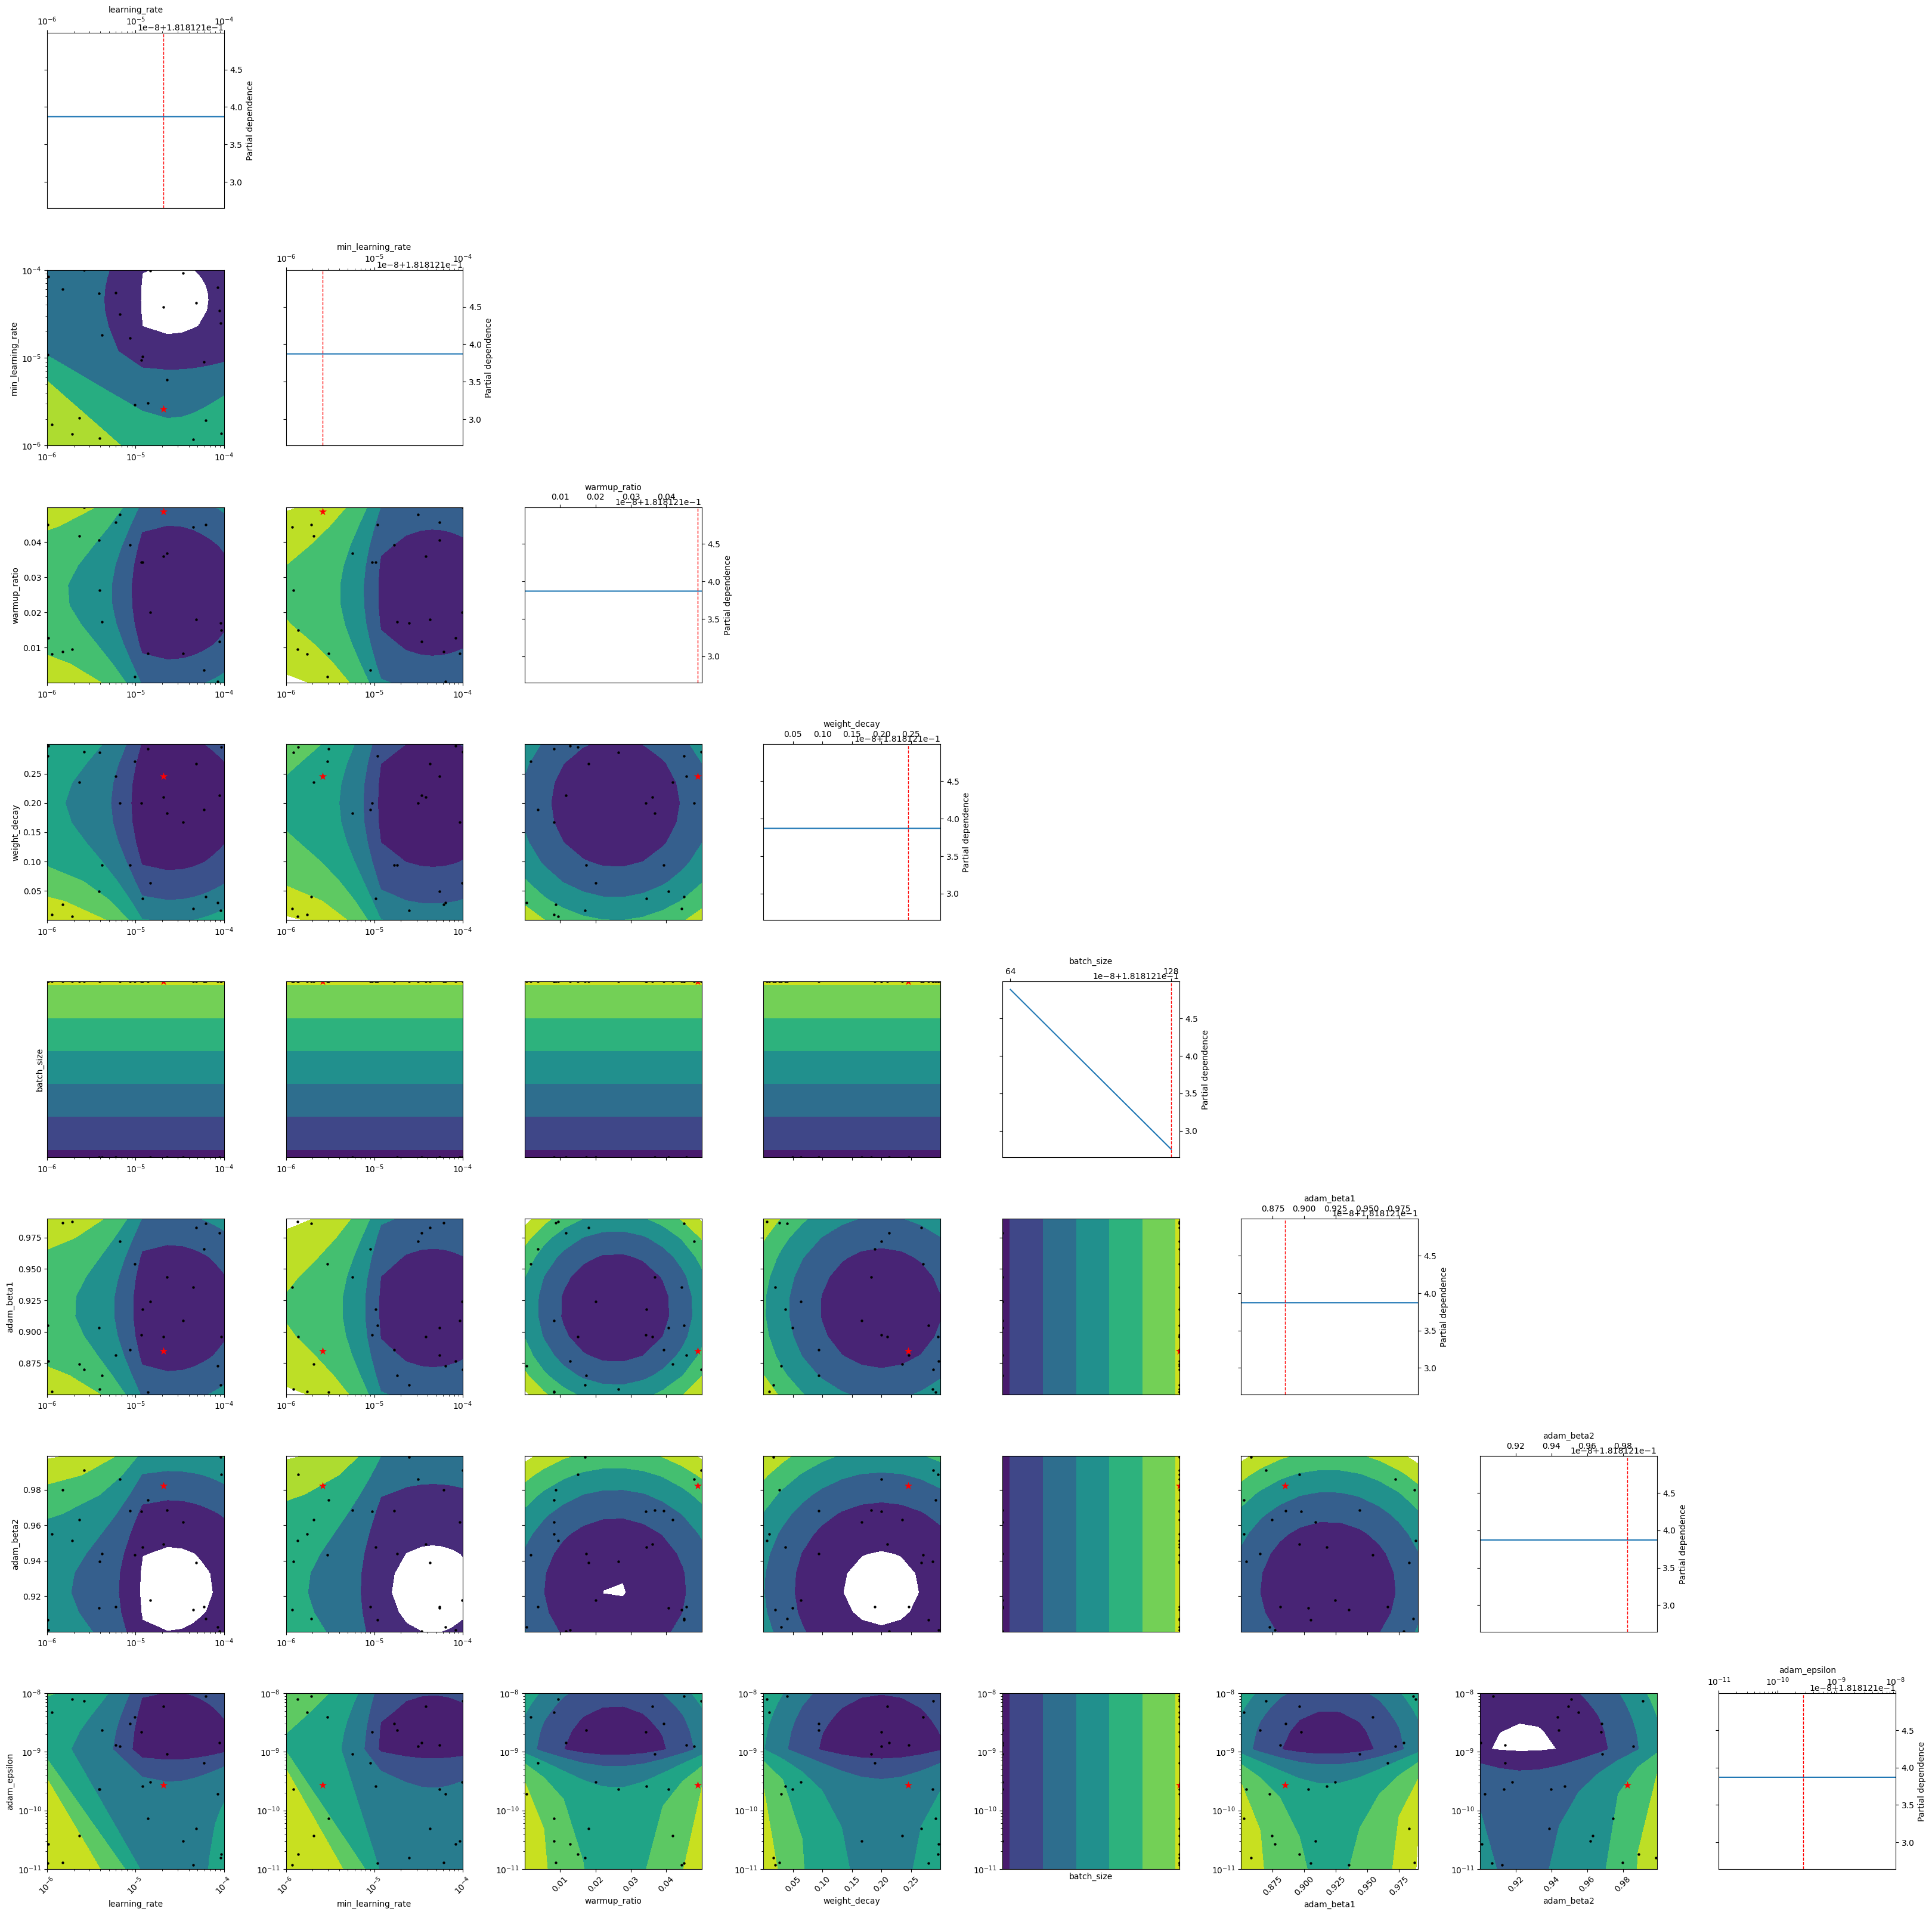

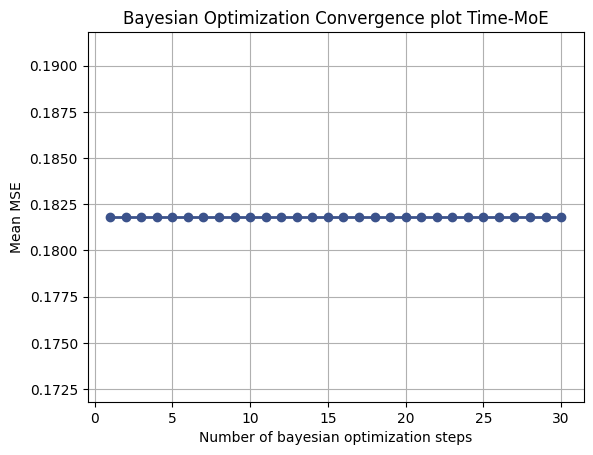

In [78]:
param_names_timemoe = [dim.name for dim in search_space_timemoe]
best_params_timemoe = {k: res_timemoe.x[i] for i, k in enumerate(param_names_timemoe)}
best_mean_mse_timemoe = res_timemoe.fun
print(f"best_params: {best_params_timemoe}")
print(f"best_mean_mse: {best_mean_mse_timemoe}")

# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_timemoe, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_timemoe)
ax.set_title("Bayesian Optimization Convergence plot Time-MoE")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

# Time-MoE supplementary analysis of hyperparameter optimization

In [89]:
print(inspect.getsource(execute_timemoe_workflow))

def execute_timemoe_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,   # remaining part is test
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 20,
  yearly_trading_days: int = 252,
  ## optimized hyperparams ##
  learning_rate=1e-4,
  min_learning_rate=5e-5,
  warmup_ratio=0.0,
  weight_decay=0.1,
  global_batch_size=64, # (just the batch size) other option would be micro_batch_size, which sets batch size per device
  adam_beta1=0.9,
  adam_beta2=0.95,
  adam_epsilon=1e-8,
  ## optimized hyperparams
  return_datasets: bool = False,
  batch_size: int = 8, # TODO: go over which batch size should be used where! (training vs test inference)
  verbose: bool = True,
  load_finetuned = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl",
  pair_tup_str: str = "(?,?)

In [95]:
search_space_timemoe = [ # 'name' is used directly as a kwarg
  ## optimized hyperparams: learning algorithm ##
  Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'), # too high of a learning rate will cause exploding gradients, resulting in very high MSE or nans in outputs
  # Real(1e-8, 1e-2, prior='log-uniform', name='min_learning_rate'),
  # Real(0.0, 0.5, name='warmup_ratio'),
  # Real(0.0, 0.5, name='weight_decay'),
  # Categorical([64, 128], name='global_batch_siz'),
  # Real(0.5, 0.99, name='adam_beta1'),
  # Real(0.5, 0.999, name='adam_beta2'),
  # Real(1e-13, 1e-6, prior='log-uniform', name='adam_epsilon')
  ## optimized hyperparams: learning algorithm ##
]
SEED = 3178749

# call func
res_timemoe = bayesian_optimize_workflow(
    execute_workflow_fn=execute_timemoe_workflow,
    top_pair_count=1,
    start_year=2008,
    min_end_year=2016,
    max_end_year=2016,
    search_space=search_space_timemoe,
    n_calls=10,
    seed=SEED,
    verbose=True
)
param_names = [dim.name for dim in search_space_timemoe]
best_params = {k: res_timemoe.x[i] for i, k in enumerate(param_names)}
best_mean_mse = res_timemoe.fun

param_names_timemoe = [dim.name for dim in search_space_timemoe]
best_params_timemoe = {k: res_timemoe.x[i] for i, k in enumerate(param_names_timemoe)}
best_mean_mse_timemoe = res_timemoe.fun
print(f"best_params: {best_params_timemoe}")
print(f"best_mean_mse: {best_mean_mse_timemoe}")

# show how dimensions relate to objective evaluation
plt.style.use('default') # set back to seaborn later!
skplots.plot_objective(res_timemoe, levels=5, n_points=10, size=5)
plt.show()

ax = skplots.plot_convergence(res_timemoe)
ax.set_title("Bayesian Optimization Convergence plot Time-MoE")
ax.set_xlabel('Number of bayesian optimization steps')
ax.set_ylabel('Mean MSE')
plt.show()

Iteration No: 1 started. Evaluating function at random point.
Current hyperparameters: {'learning_rate': 0.002047560425249196}
2025-06-16 18:28:01,455 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/Maple728/TimeMoE-50M/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/Maple728/TimeMoE-50M/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/Maple728/TimeMoE-50M/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/Maple728/TimeMoE-50M/resolve/main/config.json
Retrying in 8s [Retry 4/5].


KeyboardInterrupt: 

<Axes: >

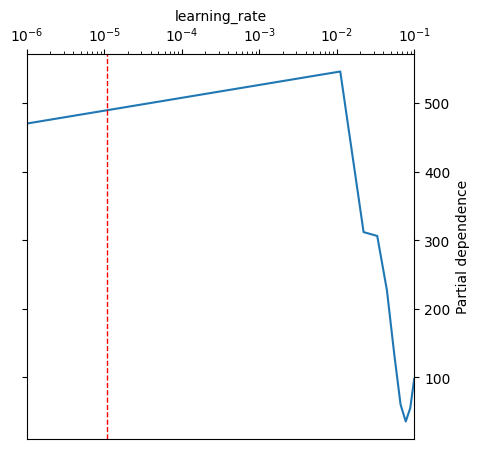

In [84]:
skplots.plot_objective(res_timemoe, levels=5, n_points=10, size=5)

In [94]:
# Do we actually get the same mse as the bayesian optimization said we should?
hyperparam_kwargs =  {'learning_rate': 0.1047560425249196, 'min_learning_rate': 1.775185258279768e-07, 'warmup_ratio': 0.48810916053081604, 'weight_decay': 0.40888317513101746, 'adam_beta1': 0.8796053325240675, 'adam_beta2': 0.622994061240289, 'adam_epsilon': 6.699584396821271e-08}
# total mse list 2016-2019: [0.3072904955890847, 0.1529728609119545, 0.08643876824821749, 0.1805463853429949]

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2016
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###
### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2016
results_timemoe_2016 = []
all_outputs_timemoe_2016 = []
num_results = min(len(pairs_data_filtered), 1)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, return_datasets=return_datasets, **hyperparam_kwargs) # train_frac, dev_frac
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_timemoe_2016.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_timemoe_2016.append(output_model)


Gathering [...]:   0%|          | 0/1 [00:00<?, ?it/s]

Split sizes — train: 2039, dev: 113, test: 114
Using device: cuda
2025-06-16 18:26:10,491 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3938.31it/s]


Step,Training Loss
1,0.030500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.1551129430330165
Test MSE: 0.30728882982371236
YOY Returns: 0.19%
YOY Std: +- 0.04%
GT Yoy: 0.19%
Plot filepath parent dir: data/results
pair_tup_str: (SMH,PEY)
  


In [ ]:
skplots.plot_objective(results_timemoe_2016, levels=5, n_points=10, size=5)

# 2. Results

In [13]:
### Unchanged variables ###
verbose = True
return_datasets = True
### Unchanged variables ###

## Kalman Filter

In [ ]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = dict(
    delta=1e-3,
    obs_cov_reg= 2.,
    trans_cov_avg= 0.01,
    obs_cov_avg= 1.
)

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
results_kalman_2022 = []
all_outputs_kalman_2022 = []
num_results = min(len(pairs_data_filtered), 8)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_kalman_2022.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_kalman_2022.append(output_model)

In [ ]:
  # test_s1_shortened=test_s1,
  # test_s2_shortened=test_s2,
  # forecast_test_shortened_series=forecast_test_series,
  # gt_test_shortened_series=gt_test_series
for i, output in enumerate(all_outputs_kalman_2022):
    # gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    # plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True)
    # plt.show()
    plt.title(f"MSE: {output['test_mse']}")
    plt.plot(output['pairs_timeseries']['Spread_Close'], label="Entire timeseries")
    # plt.plot(output['forecast_series'], label="forecast_series")
    plt.plot(output['forecast_series_normalized'], label="forecast_series_normalized")
    plt.plot(output['forecast_series_normalized_without_lookahead_bias'], label="forecast_series_normalized_without_lookahead_bias")
    plt.plot(output['forecast_series_starting_from_test_scaled_with_dev'], label="forecast_series_starting_from_test_scaled_with_dev")
    plt.plot(output['gt_test_shortened_series'], label="gt_test_shortened_series")
    plt.legend()
    plt.show()

In [ ]:
print(results_to_latex(results_kalman_2022))

## Transformer

In [57]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'d_model': 256, 'nhead': 8, 'num_layers': 3, 'dropout': 0.1423652841511892, 'learning_rate': 2.4360790710388177e-06, 'min_learning_rate': 8.416991137830168e-05, 'warmup_ratio': 0.01016486209190529, 'weight_decay': 0.27550315286937016, 'batch_size': 64, 'adam_beta1': 0.9595914559778183, 'adam_beta2': 0.9696258195959361, 'adam_epsilon': 5.235073338871379e-10}


### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
results_transformer_2024 = []
all_outputs_transformer_2024 = []
num_results = min(len(pairs_data_filtered), 10)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, epochs=300, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_transformer_2024.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_transformer_2024.append(output_model)

Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Using device: cuda
Split sizes — train: 3774, dev: 251, test: 252
Epoch 010 | train MSE 0.633990 | val MSE 0.100174
Epoch 020 | train MSE 0.249710 | val MSE 0.068498
Epoch 030 | train MSE 0.167598 | val MSE 0.046933
Epoch 040 | train MSE 0.119153 | val MSE 0.030960
Epoch 050 | train MSE 0.084400 | val MSE 0.021660
Epoch 060 | train MSE 0.071022 | val MSE 0.017767
Epoch 070 | train MSE 0.056709 | val MSE 0.016519
Epoch 080 | train MSE 0.049345 | val MSE 0.015240
Epoch 090 | train MSE 0.043051 | val MSE 0.014044
Epoch 100 | train MSE 0.039044 | val MSE 0.012503
Epoch 110 | train MSE 0.033118 | val MSE 0.011385
Epoch 120 | train MSE 0.031216 | val MSE 0.009842
Epoch 130 | train MSE 0.027169 | val MSE 0.010442
Epoch 140 | train MSE 0.027518 | val MSE 0.009631
Epoch 150 | train MSE 0.025742 | val MSE 0.008928
Epoch 160 | train MSE 0.024524 | val MSE 0.010023
Epoch 170 | train MSE 0.022956 | val MSE 0.009635
Epoch 180 | train MSE 0.028256 | val MSE 0.009445
Epoch 190 | train MSE 0.026767 | v

In [59]:
print(results_to_latex(results_transformer_2022))

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.15000 & 0.14245 & $0.11\% \pm 0.01\%$ & 0.10\% & 1.00 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.47036 & 0.29027 & $-72.77\% \pm 47.72\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.10872 & 0.15208 & $0.35\% \pm 0.02\%$ & 0.39\% & 1.00 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.08394 & 0.09651 & $0.09\% \pm 0.00\%$ & 0.05\% & 1.00 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.07015 & 0.22685 & TLOE* & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.09081 & 0.25826 & $-0.21\% \pm 0.03\%$ & -0.25\% & 1.00 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.53958 & 0.44944 & TLOE* & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.85777 & 17.19063 & $15.15\% \pm 0.46\%$ & 26.74\% & 0

In [31]:
val_targets_original_scale, val_preds_original_scale, val_preds_scaled, val_targets_scaled, dev_loader, model, trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std, devX_raw, devX_scaled, devY_raw, devY_scaled, testX_raw, testX_scaled, testY_raw, testY_scaled = output_model
dataloader = dev_loader
device = "cuda" if torch.cuda.is_available() else "cpu"
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch).cpu().numpy() # sometimes returns only nans, likely due to exploding gradients
        targets = y_batch.cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets)
all_preds = np.concatenate(all_preds).reshape(-1, 1)
all_targets = np.concatenate(all_targets).reshape(-1, 1)
all_preds, all_targets

(array([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [ ]:
for i, output in enumerate(all_outputs_transformer_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_transformer_2022_{i}")

## Time-MoE

In [98]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###
### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
results_timemoe_2024 = []
all_outputs_timemoe_2024 = []
num_results = min(len(pairs_data_filtered), 10)
for i in tqdm(range(num_results), desc = "Gathering [...]"):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pair_tup_str_current = f"({ticker_a},{ticker_b})"
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
    gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
    output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
    # print(output_model
    yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
    returns_score = return_score(output_model['yoy_mean'], gt_yoy)
    cointegration_score = pairs_data_filtered[i][1]
    results_timemoe_2024.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
    all_outputs_timemoe_2024.append(output_model)


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:47:29,898 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1857.53it/s]


Step,Training Loss
1,0.032700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09239432786604368
Test MSE: 0.0936405969555448
YOY Returns: 0.08%
YOY Std: +- 0.02%
GT Yoy: 0.10%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:47:36,536 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2477.44it/s]


Step,Training Loss
1,0.020600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.184889318564359
Test MSE: 0.09235876728035444
YOY Returns: -42.19%
YOY Std: +- 51.16%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,MBB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:47:43,067 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3682.44it/s]


Step,Training Loss
1,0.022700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08863857148718646
Test MSE: 0.07025281824257884
YOY Returns: 0.44%
YOY Std: +- 0.07%
GT Yoy: 0.39%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:47:49,607 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4253.86it/s]


Step,Training Loss
1,0.025800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06872991119045643
Test MSE: 0.08798726234386924
YOY Returns: 0.02%
YOY Std: +- 0.01%
GT Yoy: 0.05%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:47:56,437 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3778.65it/s]


Step,Training Loss
1,0.012600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05464331692859922
Test MSE: 0.1653925733205924
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:48:03,086 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3377.06it/s]


Step,Training Loss
1,0.032400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08327506033189216
Test MSE: 0.1884530334746784
YOY Returns: -0.21%
YOY Std: +- 0.05%
GT Yoy: -0.25%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:48:10,341 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3979.42it/s]


Step,Training Loss
1,0.020000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.14915839348281335
Test MSE: 0.09421923041836613
YOY Returns: -52.57%
YOY Std: +- 52.18%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,BND)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:48:16,908 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1219.27it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.020009269039528963
Test MSE: 0.14566013105789075
YOY Returns: -21.83%
YOY Std: +- 54.49%
GT Yoy: 26.74%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:48:24,016 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1870.79it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.028958209209513305
Test MSE: 0.16737905593339888
YOY Returns: -7.09%
YOY Std: +- 32.49%
GT Yoy: 11.34%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:48:30,438 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1776.49it/s]


Step,Training Loss
1,0.015600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.030388462180279508
Test MSE: 0.03280763865466177
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,PPH)
  


In [100]:
print(results_to_latex(results_timemoe_2024))

\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (PFF,EMB) & $1.38\times 10^{-4}$ & 0.09239 & 0.09364 & $0.08\% \pm 0.02\%$ & 0.10\% & 1.00 \\
2. (IFGL,MBB) & $4.45\times 10^{-4}$ & 0.18489 & 0.09236 & $-42.19\% \pm 51.16\%$ & TLOE* & nan \\
3. (IFGL,EMB) & $7.27\times 10^{-4}$ & 0.08864 & 0.07025 & $0.44\% \pm 0.07\%$ & 0.39\% & 1.00 \\
4. (IGIB,IEI) & $7.97\times 10^{-4}$ & 0.06873 & 0.08799 & $0.02\% \pm 0.01\%$ & 0.05\% & 1.00 \\
5. (IGF,DVY) & $8.40\times 10^{-4}$ & 0.05464 & 0.16539 & TLOE* & TLOE* & nan \\
6. (USIG,IEI) & $1.09\times 10^{-3}$ & 0.08328 & 0.18845 & $-0.21\% \pm 0.05\%$ & -0.25\% & 1.00 \\
7. (IFGL,BND) & $1.20\times 10^{-3}$ & 0.14916 & 0.09422 & $-52.57\% \pm 52.18\%$ & TLOE* & nan \\
8. (IFGL,SMH) & $1.64\times 10^{-3}$ & 0.02001 & 0.14566 & $-21.83\% \pm 54.4

In [ ]:
for i, output in enumerate(all_outputs_timemoe_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_timemoe_2022_{i}")

In [101]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}


results_all_years = {}
outputs_all_years = {}
for end_year in [2020, 2021, 2022, 2023, 2024]:
  ### Year-specific data ###
  startDateStr = '2008-01-01'
  endDateStr = f'{end_year}-12-31'
  startDateStrTest = f'{end_year}-01-01'
  endDateStrTest = f'{end_year}-12-31'
  train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  if pairs_data_filtered is None:
    scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
    pairs_data = {key:value[1]  for (key, value) in pairs.items()}
    pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
    pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
    save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  ### Year-specific data ###

  ### OPTIONAL: define worfklow here for debugging ###
  ### OPTIONAL: define worfklow here for debugging ###

  # Gather results for 2024
  results_timemoe_current_year = []
  all_outputs_timemoe_current_year = []
  num_results = min(len(pairs_data_filtered), 10)
  for i in tqdm(range(num_results), desc = "Gathering [...]"):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pair_tup_str_current = f"({ticker_a},{ticker_b})"
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
      gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
      output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
      # print(output_model
      yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
      returns_score = return_score(output_model['yoy_mean'], gt_yoy)
      cointegration_score = pairs_data_filtered[i][1]
      results_timemoe_current_year.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
      all_outputs_timemoe_current_year.append(output_model)
  results_all_years[end_year] = results_timemoe_current_year
  outputs_all_years[end_year] = all_outputs_timemoe_current_year


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:22,409 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2285.72it/s]


Step,Training Loss
1,0.011000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.028731317622682634
Test MSE: 0.029232571676024707
YOY Returns: -47.57%
YOY Std: +- 69.90%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,SMH)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:28,764 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2153.13it/s]


Step,Training Loss
1,0.011000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.055486505040859474
Test MSE: 0.02699584730796495
YOY Returns: -31.11%
YOY Std: +- 59.98%
GT Yoy: 33.16%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,ONEQ)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:35,780 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4946.11it/s]


Step,Training Loss
1,0.017600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.039533963248355564
Test MSE: 0.04418646772281635
YOY Returns: -59.32%
YOY Std: +- 55.14%
GT Yoy: 14.67%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,PHO)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:42,106 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4156.89it/s]


Step,Training Loss
1,0.011300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03924861595830838
Test MSE: 0.02771135571361499
YOY Returns: -26.66%
YOY Std: +- 63.59%
GT Yoy: 43.99%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,PDP)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:49,263 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1651.30it/s]


Step,Training Loss
1,0.021400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08853497749354756
Test MSE: 0.14000575473921498
YOY Returns: 0.04%
YOY Std: +- 0.02%
GT Yoy: 0.10%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:55,595 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


Step,Training Loss
1,0.039600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.12619857677832114
Test MSE: 0.22588270094159577
YOY Returns: 0.41%
YOY Std: +- 0.15%
GT Yoy: 0.71%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:02,215 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4888.47it/s]


Step,Training Loss
1,0.031400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.01812939600433806
Test MSE: 0.2989169103877188
YOY Returns: 0.06%
YOY Std: +- 0.12%
GT Yoy: -0.36%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:08,534 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


Step,Training Loss
1,0.022700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.293214297892158
Test MSE: 0.04270744196307555
YOY Returns: 0.13%
YOY Std: +- 0.23%
GT Yoy: 0.41%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SHV)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:15,034 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3826.92it/s]


Step,Training Loss
1,0.014700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.2241578474434321
Test MSE: 0.0838085686715567
YOY Returns: 0.25%
YOY Std: +- 0.10%
GT Yoy: 0.31%
Plot filepath parent dir: data/results
pair_tup_str: (PRFZ,SCZ)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:21,326 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Step,Training Loss
1,0.023600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08387993737317927
Test MSE: 0.04806774098954818
YOY Returns: 0.81%
YOY Std: +- 0.45%
GT Yoy: 0.53%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:27,953 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3554.49it/s]


Step,Training Loss
1,0.040300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.22251734012282573
Test MSE: 0.05745849903738038
YOY Returns: 0.24%
YOY Std: +- 0.08%
GT Yoy: 0.35%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:34,452 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1795.51it/s]


Step,Training Loss
1,0.025300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05222501066475606
Test MSE: 0.08541073977533668
YOY Returns: -0.15%
YOY Std: +- 0.03%
GT Yoy: -0.03%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:40,840 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1449.81it/s]


Step,Training Loss
1,0.024000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.04569871975828641
Test MSE: 0.07188018277188213
YOY Returns: 0.26%
YOY Std: +- 0.08%
GT Yoy: 0.32%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SHV)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:47,392 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2404.99it/s]


Step,Training Loss
1,0.032600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.30943457267927654
Test MSE: 0.09010725663489454
YOY Returns: 0.12%
YOY Std: +- 0.05%
GT Yoy: 0.19%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:54,894 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1823.61it/s]


Step,Training Loss
1,0.013200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.02421824103894081
Test MSE: 0.0793948808812714
YOY Returns: -1.31%
YOY Std: +- 51.50%
GT Yoy: 23.38%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:01,803 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2457.12it/s]


Step,Training Loss
1,0.013400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.022596390277692252
Test MSE: 0.08343443904123622
YOY Returns: -44.97%
YOY Std: +- 59.89%
GT Yoy: 19.67%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:07,953 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5242.88it/s]


Step,Training Loss
1,0.015600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03689494579999832
Test MSE: 0.03839222958482945
YOY Returns: 9.21%
YOY Std: +- 2.02%
GT Yoy: 12.06%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PHO)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:15,106 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1914.33it/s]


Step,Training Loss
1,0.013100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.020451985690500735
Test MSE: 0.09252138149953196
YOY Returns: -91.43%
YOY Std: +- 32.19%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PDP)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:21,401 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1716.87it/s]


Step,Training Loss
1,0.013800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.04082144594764711
Test MSE: 0.027033602262129794
YOY Returns: 9.89%
YOY Std: +- 2.83%
GT Yoy: 12.47%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,FTCS)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:27,946 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]


Step,Training Loss
1,0.025000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05010854929608761
Test MSE: 0.09891784508639302
YOY Returns: -10.79%
YOY Std: +- 31.19%
GT Yoy: -0.11%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,USIG)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:34,455 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3858.61it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06828862424413336
Test MSE: 0.050117406351387325
YOY Returns: 0.54%
YOY Std: +- 0.12%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:40,939 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


Step,Training Loss
1,0.020900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09025289187796083
Test MSE: 0.045733607630623466
YOY Returns: 0.33%
YOY Std: +- 0.13%
GT Yoy: 0.43%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:47,438 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3724.96it/s]


Step,Training Loss
1,0.025900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08830547534680415
Test MSE: 0.018602728334041016
YOY Returns: 0.87%
YOY Std: +- 0.09%
GT Yoy: 0.88%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:54,009 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5645.09it/s]


Step,Training Loss
1,0.033300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05552206316060101
Test MSE: 0.02754410127832919
YOY Returns: 0.89%
YOY Std: +- 0.30%
GT Yoy: 1.30%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:00,536 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4092.00it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09323053764187446
Test MSE: 0.20267457835229977
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:07,008 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1733.90it/s]


Step,Training Loss
1,0.022400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03012363370569058
Test MSE: 0.11510141773057263
YOY Returns: 0.07%
YOY Std: +- 0.09%
GT Yoy: 0.27%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:13,891 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2779.53it/s]


Step,Training Loss
1,0.026800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06956956762172113
Test MSE: 0.024434962520750107
YOY Returns: 0.83%
YOY Std: +- 0.34%
GT Yoy: 1.15%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:20,407 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4911.36it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06591851222600222
Test MSE: 0.1711723673348115
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:27,532 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2423.05it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06930951242712112
Test MSE: 0.19463648239859863
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:34,010 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5412.01it/s]


Step,Training Loss
1,0.013200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.030538409866746347
Test MSE: 0.05407622373936892
YOY Returns: -61.78%
YOY Std: +- 52.34%
GT Yoy: 3.70%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PHO)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:41,369 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Step,Training Loss
1,0.033100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.051087489225083625
Test MSE: 0.09097674864901062
YOY Returns: -0.02%
YOY Std: +- 0.02%
GT Yoy: -0.06%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:47,851 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2131.25it/s]


Step,Training Loss
1,0.021800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.04384337669338304
Test MSE: 0.08899245473573411
YOY Returns: 0.53%
YOY Std: +- 0.17%
GT Yoy: 0.65%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:54,319 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 6626.07it/s]


Step,Training Loss
1,0.012900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.20807959139212667
Test MSE: 0.055883216506390276
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:00,768 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5035.18it/s]


Step,Training Loss
1,0.026600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.02433241067347859
Test MSE: 0.06727071023273933
YOY Returns: 0.27%
YOY Std: +- 0.19%
GT Yoy: 0.50%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:07,271 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4173.44it/s]


Step,Training Loss
1,0.023000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.11565727872765338
Test MSE: 0.053657277040690766
YOY Returns: 0.12%
YOY Std: +- 0.03%
GT Yoy: 0.15%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:14,107 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2796.20it/s]


Step,Training Loss
1,0.034400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.02767914558707304
Test MSE: 0.08134467028652545
YOY Returns: 0.38%
YOY Std: +- 0.24%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:20,624 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2651.27it/s]


Step,Training Loss
1,0.019900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.033741189891579274
Test MSE: 0.1504577155707437
YOY Returns: 0.46%
YOY Std: +- 0.14%
GT Yoy: 0.25%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,BND)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:27,408 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5165.40it/s]


Step,Training Loss
1,0.011400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.2580275040427529
Test MSE: 0.023902816573746
YOY Returns: -8.15%
YOY Std: +- 48.13%
GT Yoy: 16.05%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:33,840 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3778.65it/s]


Step,Training Loss
1,0.020300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03106166381703263
Test MSE: 0.1868458461410914
YOY Returns: 0.25%
YOY Std: +- 0.10%
GT Yoy: -0.27%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,MBB)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:40,800 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4634.59it/s]


Step,Training Loss
1,0.011400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.22887170278987234
Test MSE: 0.03219650993311686
YOY Returns: -58.97%
YOY Std: +- 55.89%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:56:47,419 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5607.36it/s]


Step,Training Loss
1,0.032700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09239432786604368
Test MSE: 0.0936405969555448
YOY Returns: 0.08%
YOY Std: +- 0.02%
GT Yoy: 0.10%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:56:54,634 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2884.67it/s]


Step,Training Loss
1,0.020600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.184889318564359
Test MSE: 0.09235876728035444
YOY Returns: -42.19%
YOY Std: +- 51.16%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,MBB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:01,092 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2781.37it/s]


Step,Training Loss
1,0.022700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08863857148718646
Test MSE: 0.07025281824257884
YOY Returns: 0.44%
YOY Std: +- 0.07%
GT Yoy: 0.39%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:07,655 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1810.23it/s]


Step,Training Loss
1,0.025800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06872991119045643
Test MSE: 0.08798726234386924
YOY Returns: 0.02%
YOY Std: +- 0.01%
GT Yoy: 0.05%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:14,180 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5809.29it/s]


Step,Training Loss
1,0.012600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05464331692859922
Test MSE: 0.1653925733205924
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:20,740 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1423.73it/s]


Step,Training Loss
1,0.032400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08327506033189216
Test MSE: 0.1884530334746784
YOY Returns: -0.21%
YOY Std: +- 0.05%
GT Yoy: -0.25%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:27,263 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2690.38it/s]


Step,Training Loss
1,0.020000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.14915839348281335
Test MSE: 0.09421923041836613
YOY Returns: -52.57%
YOY Std: +- 52.18%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,BND)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:33,786 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3894.43it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.020009269039528963
Test MSE: 0.14566013105789075
YOY Returns: -21.83%
YOY Std: +- 54.49%
GT Yoy: 26.74%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:40,453 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4588.95it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.028958209209513305
Test MSE: 0.16737905593339888
YOY Returns: -7.09%
YOY Std: +- 32.49%
GT Yoy: 11.34%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:46,988 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1696.04it/s]


Step,Training Loss
1,0.015600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.030388462180279508
Test MSE: 0.03280763865466177
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,PPH)
  


In [102]:
for year, result_current in results_all_years.items():
  print(year)
  print(results_to_latex(result_current))

2020
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (SHV,SMH) & $2.46\times 10^{-4}$ & 0.02873 & 0.02923 & $-47.57\% \pm 69.90\%$ & TLOE* & nan \\
2. (SHV,ONEQ) & $4.04\times 10^{-4}$ & 0.05549 & 0.02700 & $-31.11\% \pm 59.98\%$ & 33.16\% & 0.52 \\
3. (SHV,PHO) & $4.13\times 10^{-4}$ & 0.03953 & 0.04419 & $-59.32\% \pm 55.14\%$ & 14.67\% & 0.35 \\
4. (SHV,PDP) & $9.15\times 10^{-4}$ & 0.03925 & 0.02771 & $-26.66\% \pm 63.59\%$ & 43.99\% & 0.51 \\
5. (DVY,PEY) & $1.41\times 10^{-3}$ & 0.08853 & 0.14001 & $0.04\% \pm 0.02\%$ & 0.10\% & 1.00 \\
6. (PFF,EMB) & $1.45\times 10^{-3}$ & 0.12620 & 0.22588 & $0.41\% \pm 0.15\%$ & 0.71\% & 1.00 \\
7. (IGSB,BND) & $1.56\times 10^{-3}$ & 0.01813 & 0.29892 & $0.06\% \pm 0.12\%$ & -0.36\% & 1.00 \\
8. (IFGL,SHV) & $3.95\times 10^{-3}$ & 0.29321 & 